In [1]:
#importing Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score,train_test_split,RandomizedSearchCV

from keras.optimizers import Adam
#from kerastuner.tuners import RandomSearch
from tensorflow.keras import layers
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils import np_utils
from keras.constraints import maxnorm
from keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression


import warnings
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv(r"D:\ExcelR Data Science\Assignments\Neural Networks\gas_turbines.csv",encoding='utf-8')
df.head()

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
0,6.8594,1007.9,96.799,3.5000,19.663,1059.2,550.00,114.70,10.605,3.1547,82.722
1,6.7850,1008.4,97.118,3.4998,19.728,1059.3,550.00,114.72,10.598,3.2363,82.776
2,6.8977,1008.8,95.939,3.4824,19.779,1059.4,549.87,114.71,10.601,3.2012,82.468
3,7.0569,1009.2,95.249,3.4805,19.792,1059.6,549.99,114.72,10.606,3.1923,82.670
4,7.3978,1009.7,95.150,3.4976,19.765,1059.7,549.98,114.72,10.612,3.2484,82.311


In [3]:
df.shape

(15039, 11)

In [4]:
df.describe()

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
count,15039.000000,15039.00000,15039.000000,15039.000000,15039.000000,15039.000000,15039.000000,15039.000000,15039.000000,15039.000000,15039.000000
mean,17.764381,1013.19924,79.124174,4.200294,25.419061,1083.798770,545.396183,134.188464,12.102353,1.972499,68.190934
std,7.574323,6.41076,13.793439,0.760197,4.173916,16.527806,7.866803,15.829717,1.103196,2.222206,10.470586
min,0.522300,985.85000,30.344000,2.087400,17.878000,1000.800000,512.450000,100.170000,9.904400,0.000388,27.765000
25%,11.408000,1008.90000,69.750000,3.723900,23.294000,1079.600000,542.170000,127.985000,11.622000,0.858055,61.303500
50%,18.186000,1012.80000,82.266000,4.186200,25.082000,1088.700000,549.890000,133.780000,12.025000,1.390200,66.601000
75%,23.862500,1016.90000,90.043500,4.550900,27.184000,1096.000000,550.060000,140.895000,12.578000,2.160400,73.935500
max,34.929000,1034.20000,100.200000,7.610600,37.402000,1100.800000,550.610000,174.610000,15.081000,44.103000,119.890000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15039 entries, 0 to 15038
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      15039 non-null  float64
 1   AP      15039 non-null  float64
 2   AH      15039 non-null  float64
 3   AFDP    15039 non-null  float64
 4   GTEP    15039 non-null  float64
 5   TIT     15039 non-null  float64
 6   TAT     15039 non-null  float64
 7   TEY     15039 non-null  float64
 8   CDP     15039 non-null  float64
 9   CO      15039 non-null  float64
 10  NOX     15039 non-null  float64
dtypes: float64(11)
memory usage: 1.3 MB


In [6]:
df.isnull().sum()

AT      0
AP      0
AH      0
AFDP    0
GTEP    0
TIT     0
TAT     0
TEY     0
CDP     0
CO      0
NOX     0
dtype: int64

In [7]:
numerical_features = df.describe(include=["int64","float64"]).columns
numerical_features

Index(['AT', 'AP', 'AH', 'AFDP', 'GTEP', 'TIT', 'TAT', 'TEY', 'CDP', 'CO',
       'NOX'],
      dtype='object')

### Exploratory Data Analysis

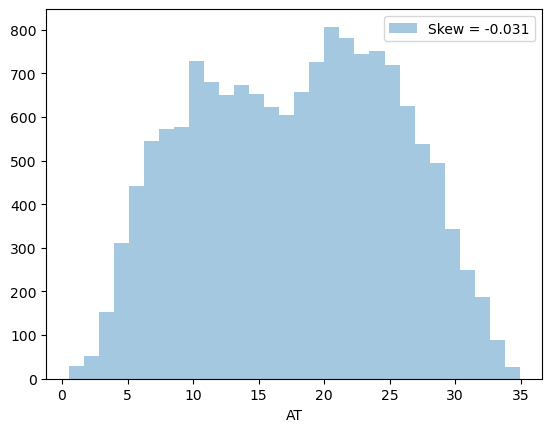

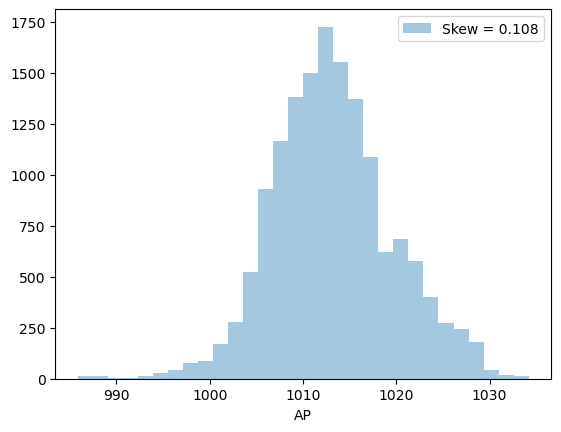

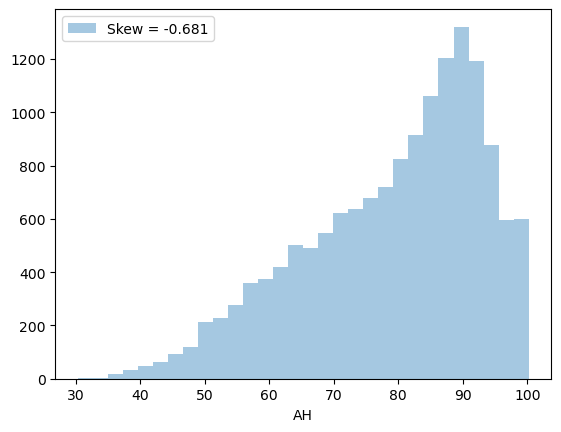

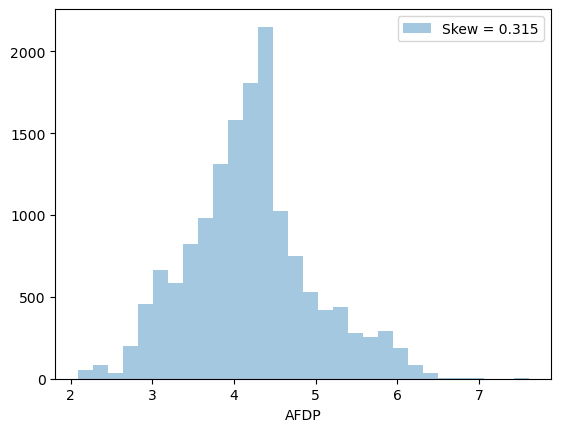

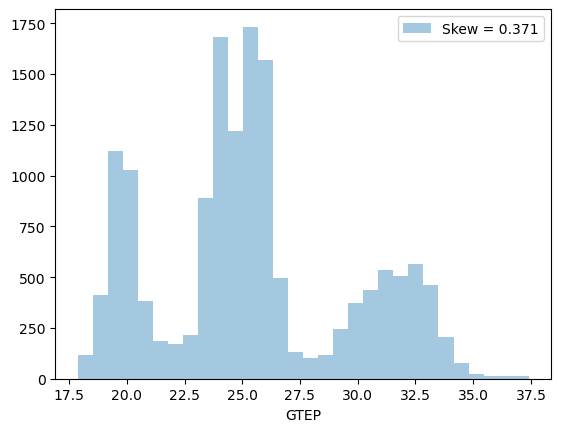

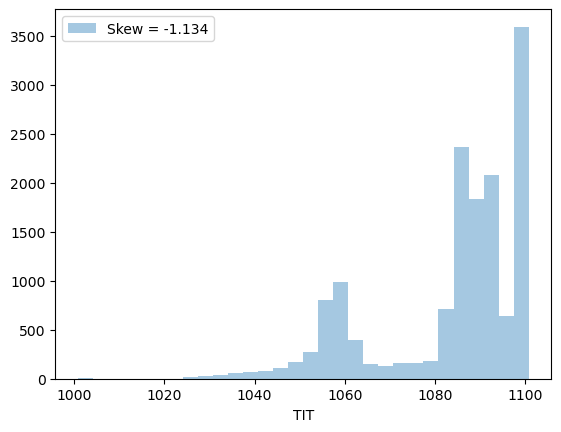

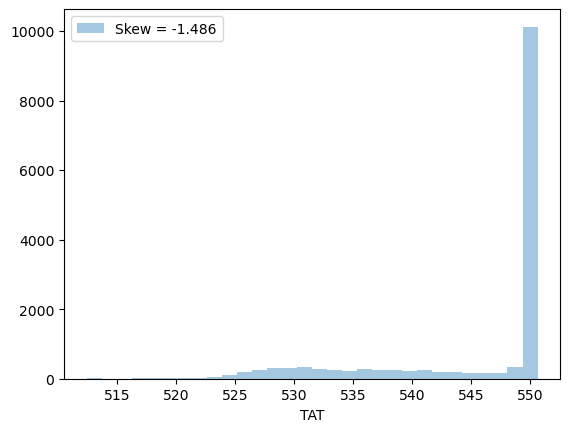

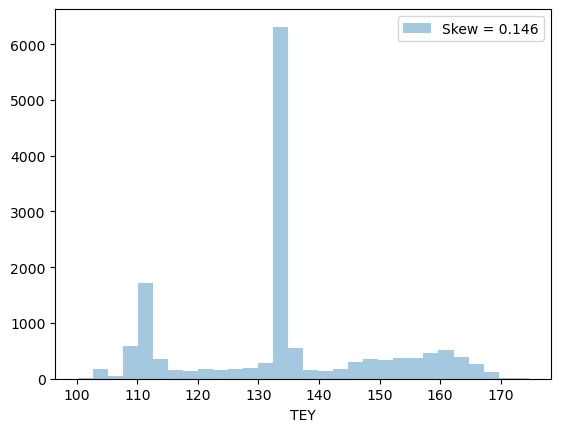

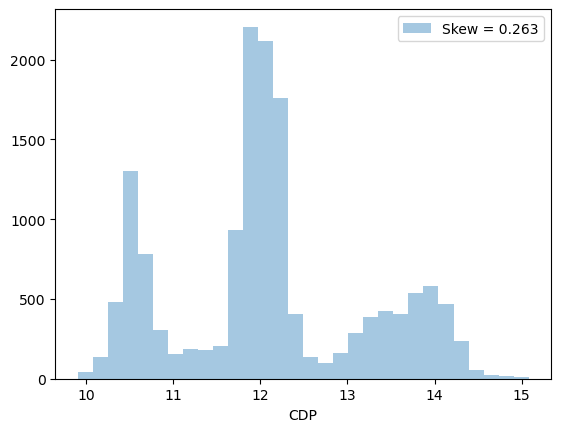

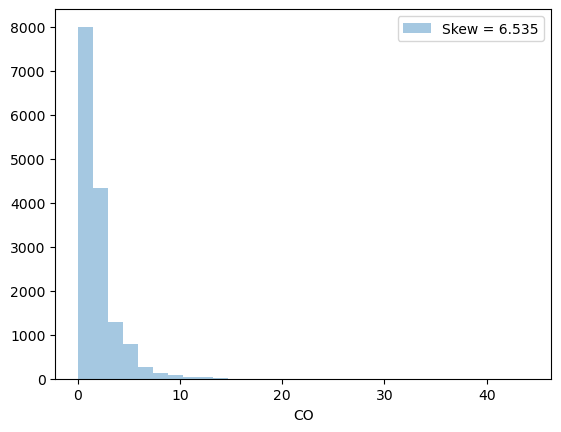

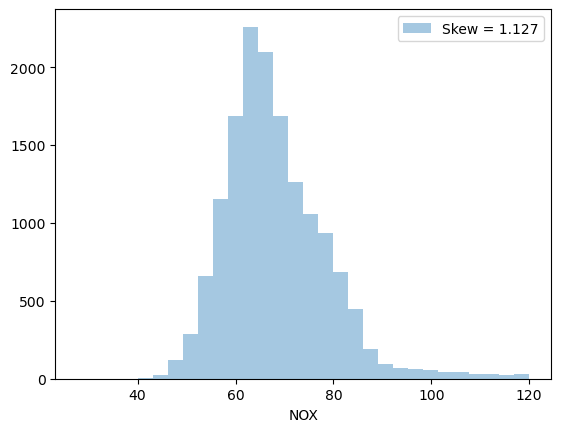

In [8]:
# Univariate ANalysis


numerical_features=[feature for feature in df.columns if df[feature].dtypes != 'O']
for i in numerical_features:
    skew = df[i].skew()
    sns.distplot(df[i], kde= False, label='Skew = %.3f' %(skew), bins=30)
    plt.legend(loc='best')
    plt.show()

Some of the features are normally distributed. The features AH, CO, TITy and TATa exhibit the highest skew coefficients. Moreover, the distribution of Carbon Mono oxide (CO) and Turbine inlet temperature (TIT) and Turbine after temperature (TAT) seem to contain many outliers. Let's identify the indices of the observations containing outliers using Turkey's method.

In [9]:
# Outlier Detection
from collections import Counter
def outlier_hunt(df):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than 2 outliers. 
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in df.columns.tolist():
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        
        # Interquartile rrange (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > 2 )
    
    return multiple_outliers   

print('The dataset contains %d observations with more than 2 outliers' %(len(outlier_hunt(df[numerical_features])))) 

The dataset contains 1543 observations with more than 2 outliers


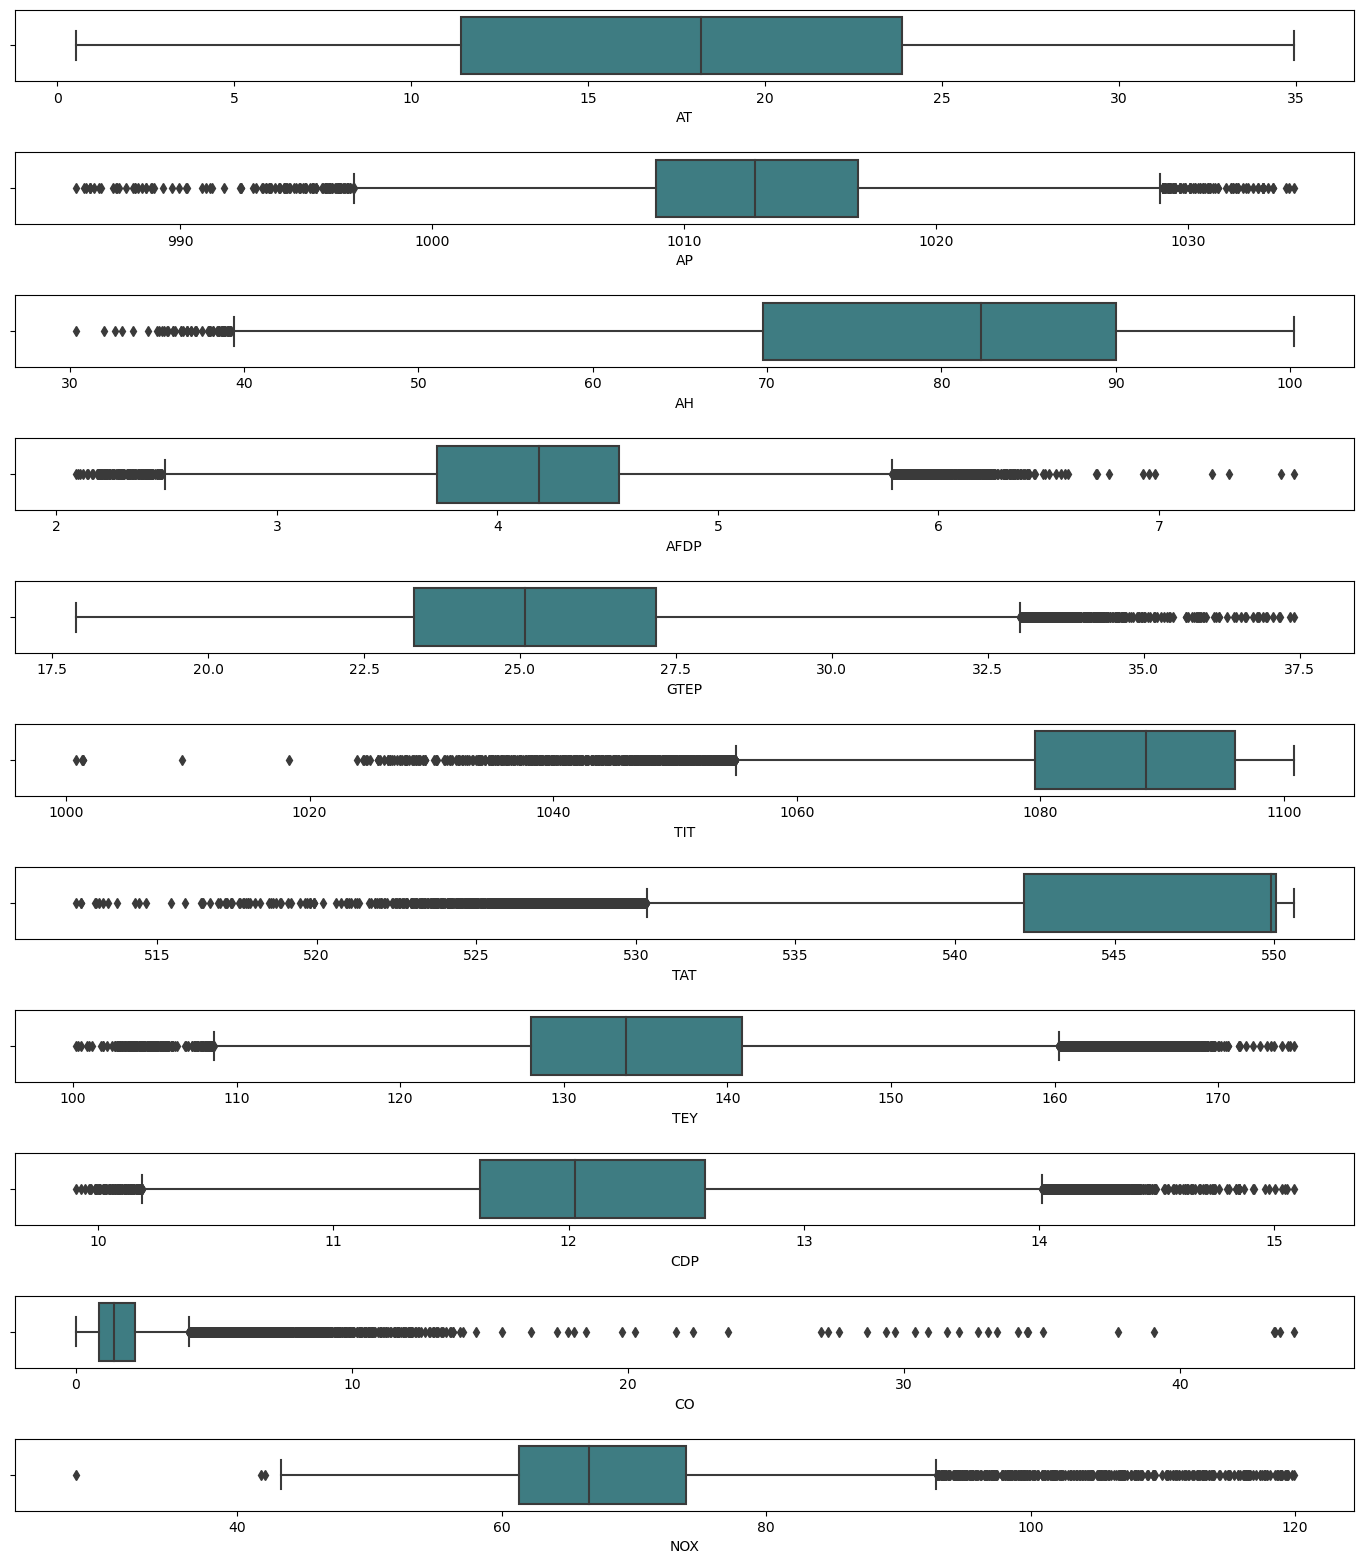

In [10]:
#Outlier visualization using boxplot

ot=df.copy() 
fig, axes=plt.subplots(11,1,figsize=(14,16),sharex=False,sharey=False)
sns.boxplot(x='AT',data=ot,palette='crest',ax=axes[0])
sns.boxplot(x='AP',data=ot,palette='crest',ax=axes[1])
sns.boxplot(x='AH',data=ot,palette='crest',ax=axes[2])
sns.boxplot(x='AFDP',data=ot,palette='crest',ax=axes[3])
sns.boxplot(x='GTEP',data=ot,palette='crest',ax=axes[4])
sns.boxplot(x='TIT',data=ot,palette='crest',ax=axes[5])
sns.boxplot(x='TAT',data=ot,palette='crest',ax=axes[6])
sns.boxplot(x='TEY',data=ot,palette='crest',ax=axes[7])
sns.boxplot(x='CDP',data=ot,palette='crest',ax=axes[8])
sns.boxplot(x='CO',data=ot,palette='crest',ax=axes[9])
sns.boxplot(x='NOX',data=ot,palette='crest',ax=axes[10])
plt.tight_layout(pad=2.0)

Text(0.5, 1.0, 'Cumulative of the Target Column')

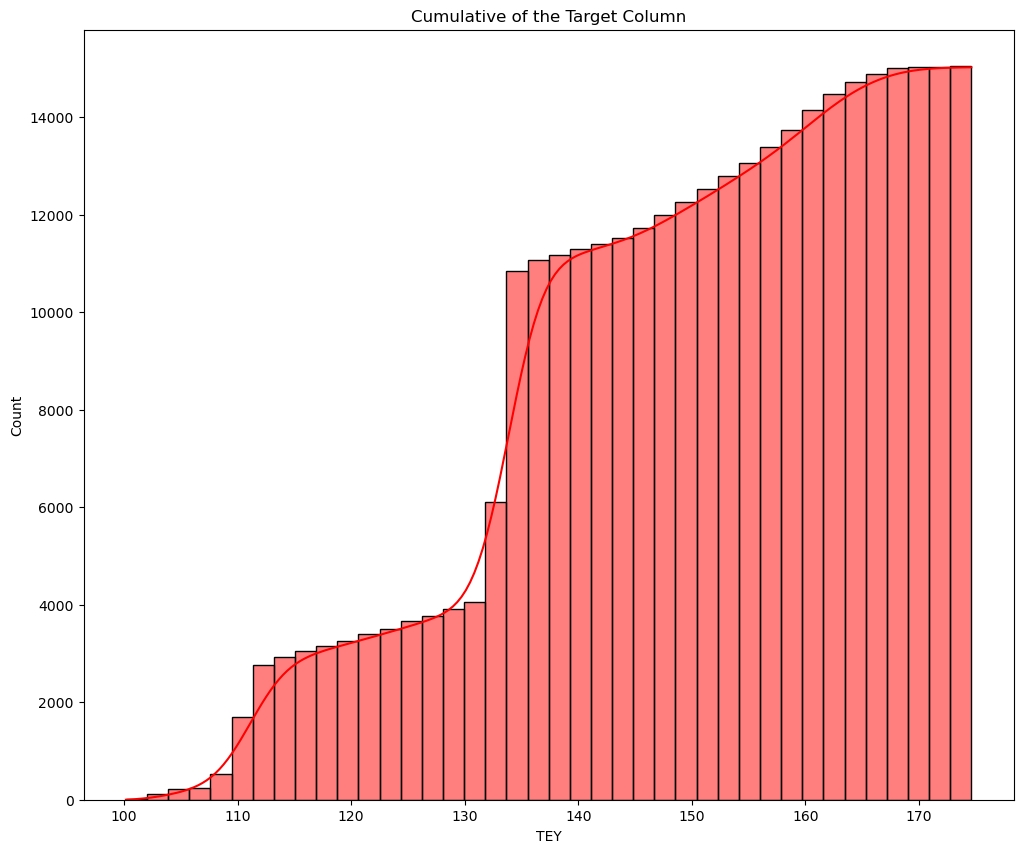

In [11]:
plt.figure(figsize = (12,10))
sns.histplot(df["TEY"],kde=True,bins=40,color="red",cumulative=True)
plt.title("Cumulative of the Target Column")

Text(0.5, 1.0, 'Correlation between the features')

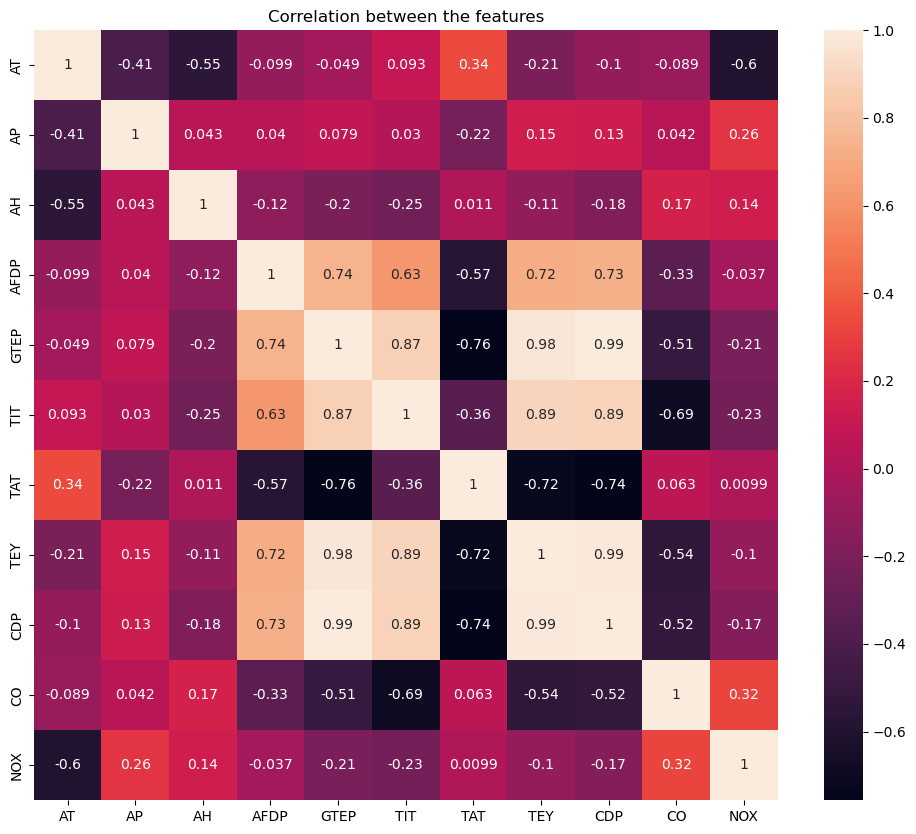

In [12]:

plt.figure(figsize = (12,10))
sns.heatmap(df.corr(),annot=True)
plt.title("Correlation between the features")

In [13]:
df.corr()['TEY'].sort_values(ascending=False)

TEY     1.000000
CDP     0.988473
GTEP    0.977042
TIT     0.891587
AFDP    0.717995
AP      0.146939
NOX    -0.102631
AH     -0.110272
AT     -0.207495
CO     -0.541751
TAT    -0.720356
Name: TEY, dtype: float64

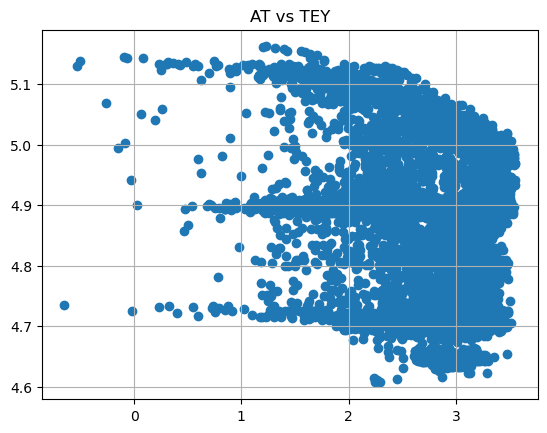

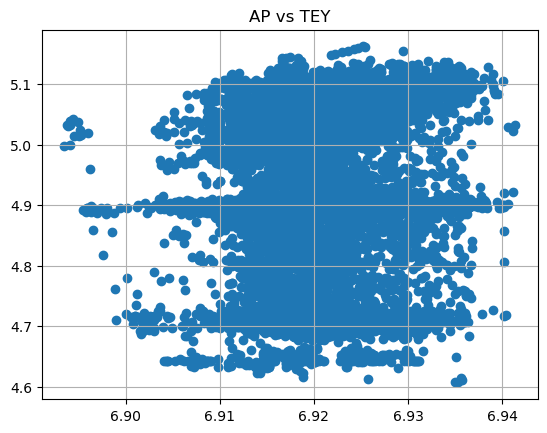

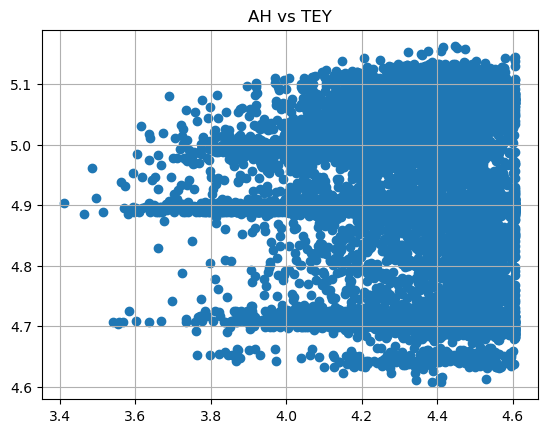

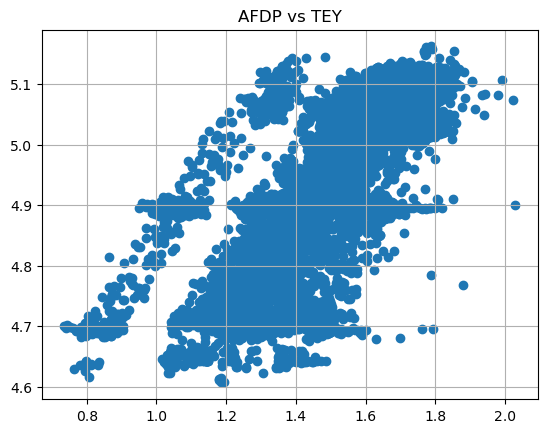

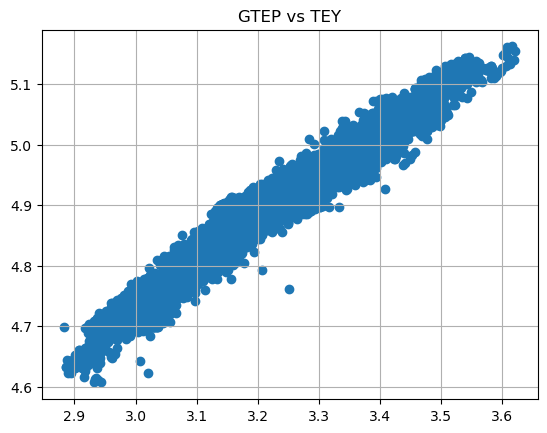

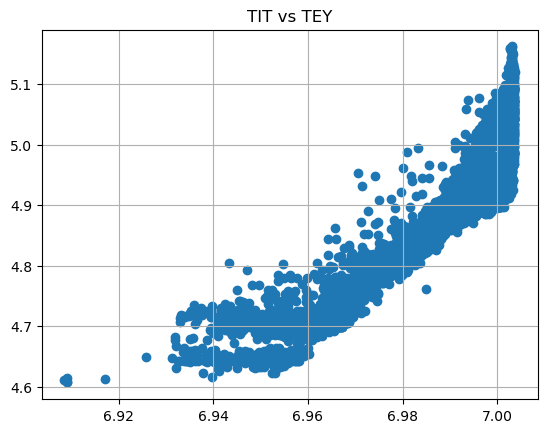

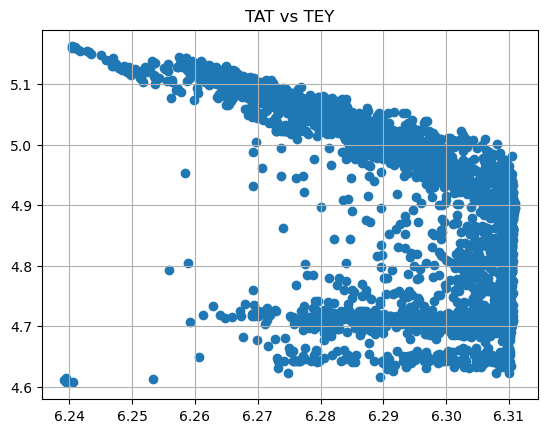

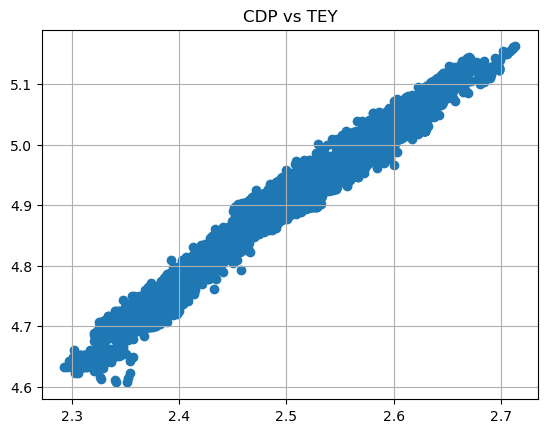

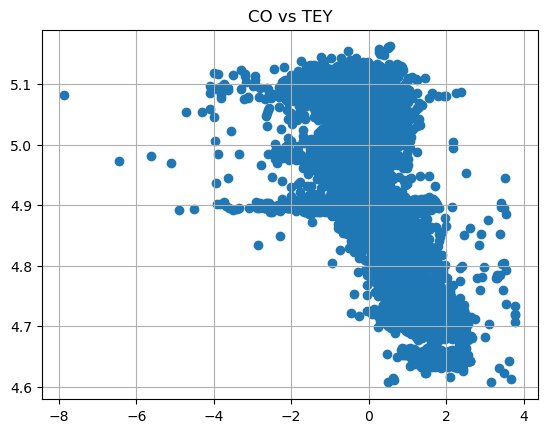

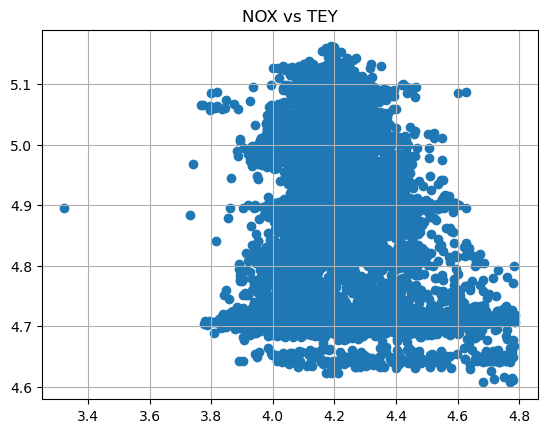

In [14]:
# MultiVariate Analysis
# Pairplot to examiene the corelation between features
for i in df.columns:
    if i!="TEY": 
        plt.scatter(np.log(df[i]), np.log(df['TEY']))
        plt.title(i+ ' vs TEY')
        plt.grid()
        plt.show()

<AxesSubplot:>

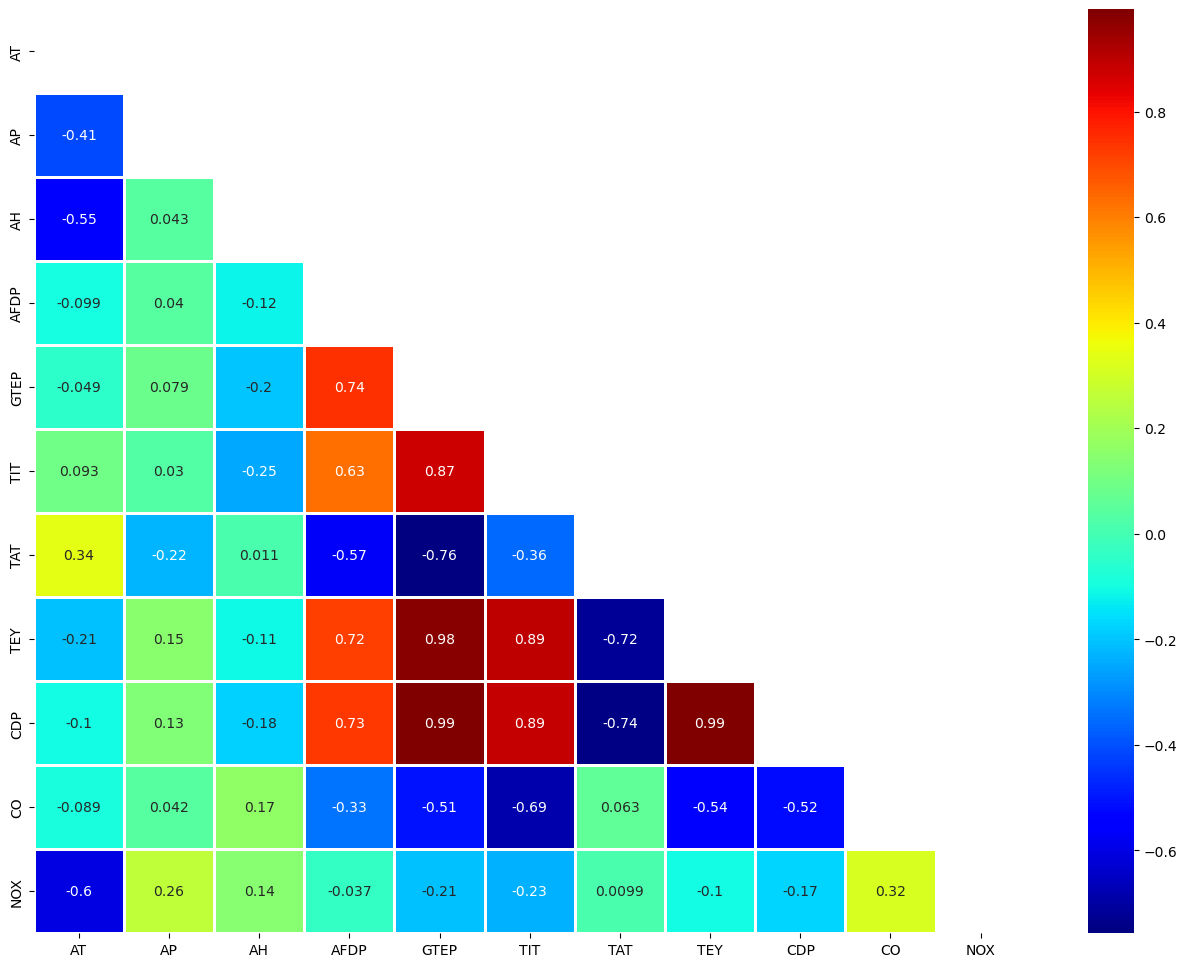

In [15]:

plt.figure(figsize=(16,12))
mask = np.zeros_like(df.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(data=df.corr(), cmap="jet", annot=True,linewidths=1, linecolor='white',mask=mask)

In [16]:
# Normalizing the dataset
scaler = StandardScaler()
for i in df.columns:
    df[i]=scaler.fit_transform(df[i].values.reshape(-1,1))


In [17]:
df.head()

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
0,-1.439778,-0.826644,1.281436,-0.921232,-1.379101,-1.488376,0.585240,-1.231172,-1.357331,0.532012,1.387845
1,-1.449601,-0.748647,1.304564,-0.921495,-1.363528,-1.482325,0.585240,-1.229909,-1.363676,0.568733,1.393002
2,-1.434721,-0.686250,1.219086,-0.944385,-1.351309,-1.476275,0.568715,-1.230541,-1.360957,0.552938,1.363586
3,-1.413702,-0.623853,1.169060,-0.946884,-1.348194,-1.464173,0.583969,-1.229909,-1.356424,0.548933,1.382878
4,-1.368693,-0.545857,1.161883,-0.924389,-1.354663,-1.458123,0.582698,-1.229909,-1.350985,0.574179,1.348591


In [18]:
x=df.drop('TEY',axis=1)

In [19]:
y=df['TEY']

In [20]:

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=42)

In [21]:
def create_model():
    model1 = Sequential()
    model1.add(Dense(32,input_dim=10,activation='relu'))
    model1.add(Dense(64,activation='relu'))
    model1.add(Dense(96,activation="relu"))
    model1.add(Dense(32,activation="relu"))
    model1.add(Dense(64,activation="relu"))
    model1.add(Dense(32,activation="relu"))
    model1.add(Dense(96,activation="relu"))
    model1.add(Dense(96,activation="relu"))
    model1.add(Dense(32,activation="relu"))
    model1.add(Dense(64,activation="relu"))
    model1.add(Dense(64,activation="relu"))
    model1.add(Dense(units=1,activation="linear"))
    
    adam=Adam(learning_rate=0.001)
    model1.compile(loss='mean_absolute_error',optimizer = adam,metrics=["mean_absolute_error"])
    return model1

In [22]:

model1 =KerasRegressor(build_fn=create_model,verbose=0)
batch_size=[10,20,40,50]
epochs=[10,50,100,200]
param_grid=dict(batch_size=batch_size,epochs=epochs)
grid = GridSearchCV(estimator=model1,param_grid=param_grid,cv=KFold(),verbose=10)

In [23]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(10527, 10)
(4512, 10)
(10527,)
(4512,)


In [24]:
#grid_result = grid.fit(x_test,y_test)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5; 1/16] START batch_size=10, epochs=10...................................
[CV 1/5; 1/16] END ...batch_size=10, epochs=10;, score=-0.065 total time= 1.4min
[CV 2/5; 1/16] START batch_size=10, epochs=10...................................
[CV 2/5; 1/16] END ...batch_size=10, epochs=10;, score=-0.045 total time=   9.0s
[CV 3/5; 1/16] START batch_size=10, epochs=10...................................
[CV 3/5; 1/16] END ...batch_size=10, epochs=10;, score=-0.066 total time=   8.2s
[CV 4/5; 1/16] START batch_size=10, epochs=10...................................
[CV 4/5; 1/16] END ...batch_size=10, epochs=10;, score=-0.036 total time=   8.3s
[CV 5/5; 1/16] START batch_size=10, epochs=10...................................
[CV 5/5; 1/16] END ...batch_size=10, epochs=10;, score=-0.070 total time=   7.2s
[CV 1/5; 2/16] START batch_size=10, epochs=50...................................
[CV 1/5; 2/16] END ...batch_size=10, epochs=50;,

[CV 1/5; 11/16] END .batch_size=40, epochs=100;, score=-0.024 total time=  22.4s
[CV 2/5; 11/16] START batch_size=40, epochs=100.................................
[CV 2/5; 11/16] END .batch_size=40, epochs=100;, score=-0.027 total time=  23.3s
[CV 3/5; 11/16] START batch_size=40, epochs=100.................................
[CV 3/5; 11/16] END .batch_size=40, epochs=100;, score=-0.036 total time=  27.0s
[CV 4/5; 11/16] START batch_size=40, epochs=100.................................
[CV 4/5; 11/16] END .batch_size=40, epochs=100;, score=-0.031 total time=  25.0s
[CV 5/5; 11/16] START batch_size=40, epochs=100.................................
[CV 5/5; 11/16] END .batch_size=40, epochs=100;, score=-0.033 total time=  25.1s
[CV 1/5; 12/16] START batch_size=40, epochs=200.................................
[CV 1/5; 12/16] END .batch_size=40, epochs=200;, score=-0.047 total time= 1.0min
[CV 2/5; 12/16] START batch_size=40, epochs=200.................................
[CV 2/5; 12/16] END .batch_s

In [25]:
print('Best {}, using {}'.format(grid_result.best_score_,grid_result.best_params_))
means = grid_result.cv_results_["mean_test_score"]
stds = grid_result.cv_results_["std_test_score"]
params = grid_result.cv_results_["params"]
for mean,stdev,param in zip(means,stds,params):
    print("{},{} with {}".format(mean,stdev,param))

Best -0.026260102912783623, using {'batch_size': 10, 'epochs': 200}
-0.05642642304301262,0.013193544898740668 with {'batch_size': 10, 'epochs': 10}
-0.035240496322512624,0.0055762306443996575 with {'batch_size': 10, 'epochs': 50}
-0.03142716810107231,0.0032311497255093284 with {'batch_size': 10, 'epochs': 100}
-0.026260102912783623,0.0019519031353704235 with {'batch_size': 10, 'epochs': 200}
-0.04015480056405067,0.005706584142450105 with {'batch_size': 20, 'epochs': 10}
-0.03084108978509903,0.0036972382990430406 with {'batch_size': 20, 'epochs': 50}
-0.03090529665350914,0.005539436072898613 with {'batch_size': 20, 'epochs': 100}
-0.027502218261361122,0.003438446049742969 with {'batch_size': 20, 'epochs': 200}
-0.04444910138845444,0.005380108206531123 with {'batch_size': 40, 'epochs': 10}
-0.033054455742239953,0.0034522982611463727 with {'batch_size': 40, 'epochs': 50}
-0.030225375294685365,0.004197453832044094 with {'batch_size': 40, 'epochs': 100}
-0.03150304853916168,0.00820180131136

In [27]:
# Model HUildinf Neuaral Networks

# since we have continuous ouput, AF is not required in the o/p layer
model = Sequential()
model.add( Dense( units = 50 , activation = 'relu' , kernel_initializer = 'normal', input_dim = 10)) # input layer
model.add( Dense( units = 20 , activation = 'tanh' , kernel_initializer = 'normal' )) # hidden layer
model.add( Dense( units = 1  , kernel_initializer = 'normal' )) # o/p layer

model.compile(optimizer= "adam", loss="mse", metrics= ["mae", "mse"])
model.fit(x_train, y_train , batch_size=50, validation_split=0.3, epochs=100,  verbose=1)

Epoch 1/100
148/148 [==============================] - 2s 7ms/step - loss: 0.2250 - mae: 0.2594 - mse: 0.2250 - val_loss: 0.0142 - val_mae: 0.0793 - val_mse: 0.0142
Epoch 2/100
148/148 [==============================] - 1s 4ms/step - loss: 0.0076 - mae: 0.0588 - mse: 0.0076 - val_loss: 0.0047 - val_mae: 0.0476 - val_mse: 0.0047
Epoch 3/100
148/148 [==============================] - 1s 4ms/step - loss: 0.0041 - mae: 0.0444 - mse: 0.0041 - val_loss: 0.0037 - val_mae: 0.0422 - val_mse: 0.0037
Epoch 4/100
148/148 [==============================] - 1s 7ms/step - loss: 0.0034 - mae: 0.0409 - mse: 0.0034 - val_loss: 0.0031 - val_mae: 0.0394 - val_mse: 0.0031
Epoch 5/100
148/148 [==============================] - 1s 5ms/step - loss: 0.0029 - mae: 0.0385 - mse: 0.0029 - val_loss: 0.0027 - val_mae: 0.0374 - val_mse: 0.0027
Epoch 6/100
148/148 [==============================] - 1s 4ms/step - loss: 0.0026 - mae: 0.0365 - mse: 0.0026 - val_loss: 0.0025 - val_mae: 0.0366 - val_mse: 0.0025
Epoch 7/10

148/148 [==============================] - 0s 3ms/step - loss: 0.0012 - mae: 0.0254 - mse: 0.0012 - val_loss: 0.0012 - val_mae: 0.0251 - val_mse: 0.0012
Epoch 51/100
148/148 [==============================] - 0s 3ms/step - loss: 0.0013 - mae: 0.0258 - mse: 0.0013 - val_loss: 0.0012 - val_mae: 0.0254 - val_mse: 0.0012
Epoch 52/100
148/148 [==============================] - 1s 4ms/step - loss: 0.0013 - mae: 0.0258 - mse: 0.0013 - val_loss: 0.0013 - val_mae: 0.0253 - val_mse: 0.0013
Epoch 53/100
148/148 [==============================] - 1s 4ms/step - loss: 0.0012 - mae: 0.0254 - mse: 0.0012 - val_loss: 0.0013 - val_mae: 0.0265 - val_mse: 0.0013
Epoch 54/100
148/148 [==============================] - 1s 4ms/step - loss: 0.0012 - mae: 0.0253 - mse: 0.0012 - val_loss: 0.0011 - val_mae: 0.0235 - val_mse: 0.0011
Epoch 55/100
148/148 [==============================] - 1s 4ms/step - loss: 0.0013 - mae: 0.0254 - mse: 0.0013 - val_loss: 0.0013 - val_mae: 0.0246 - val_mse: 0.0013
Epoch 56/100
148/

148/148 [==============================] - 1s 4ms/step - loss: 0.0011 - mae: 0.0240 - mse: 0.0011 - val_loss: 0.0011 - val_mae: 0.0233 - val_mse: 0.0011
Epoch 100/100
148/148 [==============================] - 1s 4ms/step - loss: 0.0011 - mae: 0.0243 - mse: 0.0011 - val_loss: 0.0011 - val_mae: 0.0237 - val_mse: 0.0011


In [34]:
def toFindBestParams(x_train, y_train, x_test, y_test):
        
    #defining list of hyperparameters
    batch_size_list = [5 , 10 , 15 , 20]
    epoch_list      = [5 , 10 , 50 , 100]
     
    bestParamTable = pd.DataFrame()
    
    for batch_trial in batch_size_list:
        for epochs_trial in epoch_list:
            
            # create ANN model
            model = Sequential()
            # Defining the first layer of the model
            model.add(Dense(units=50, input_dim=10, kernel_initializer='normal', activation='relu'))
            
            # Defining the Second layer of the model
            model.add(Dense(units=20, kernel_initializer='normal', activation='tanh'))
 
            # The output neuron is a single fully connected node 
            # Since we will be predicting a single number
            model.add(Dense(1, kernel_initializer='normal'))
 
            # Compiling the model
            model.compile(optimizer ='adam', loss = 'mean_squared_error')
            
            # Fitting the ANN to the Training set
            model.fit(x_train, y_train , batch_size=batch_trial, epochs=epochs_trial,  verbose=0)
            y_pred = model.predict(x_test).flatten()            
            MAPE = np.mean(100 * (np.abs(y_test-y_pred)/y_test))  
                        
            bestParamTable=bestParamTable.append(pd.DataFrame(data=[[batch_trial, epochs_trial, 100-MAPE]],
                                                        columns=['batchsize','epochs','Accuracy'] ))
            
            # printing the results of the current iteration
            print('batch_size:', batch_trial,'-', 'epochs:',epochs_trial, 'Accuracy:',100-MAPE)

    return bestParamTable
# Calling the function
finalParamTable = toFindBestParams(x_train, y_train, x_test, y_test)
finalParamTable


141/141 [==============================] - 0s 1ms/step
batch_size: 5 - epochs: 5 Accuracy: 68.79844541502004
141/141 [==============================] - 0s 2ms/step
batch_size: 5 - epochs: 10 Accuracy: 80.95648337527918
141/141 [==============================] - 0s 2ms/step
batch_size: 5 - epochs: 50 Accuracy: 60.1283903509105
141/141 [==============================] - 0s 2ms/step
batch_size: 5 - epochs: 100 Accuracy: 63.9103431090309
141/141 [==============================] - 0s 2ms/step
batch_size: 10 - epochs: 5 Accuracy: 60.00765711806967
141/141 [==============================] - 0s 2ms/step
batch_size: 10 - epochs: 10 Accuracy: 63.56022678933114
141/141 [==============================] - 0s 2ms/step
batch_size: 10 - epochs: 50 Accuracy: 80.54202911623318
141/141 [==============================] - 0s 2ms/step
batch_size: 10 - epochs: 100 Accuracy: 68.33557859465537
141/141 [==============================] - 0s 2ms/step
batch_size: 15 - epochs: 5 Accuracy: 53.2303564405306
141/141 [

,batchsize,epochs,Accuracy
0,5,5,68.798445
0,5,10,80.956483
0,5,50,60.128390
0,5,100,63.910343
0,10,5,60.007657
0,10,10,63.560227
0,10,50,80.542029
0,10,100,68.335579
0,15,5,53.230356
0,15,10,82.543298


In [36]:
# getting corresponding row values of the maximum value of 'Accuracy' column
finalParamTable = finalParamTable.reset_index()
#print(finalParamTable_1)
#print(finalParamTable['Accuracy'].idxmax())
finalParamTable.iloc[finalParamTable['Accuracy'].idxmax()]

index         0.000000
batchsize    15.000000
epochs       10.000000
Accuracy     82.543298
Name: 9, dtype: float64

### Model Evaluation Train and Test Error

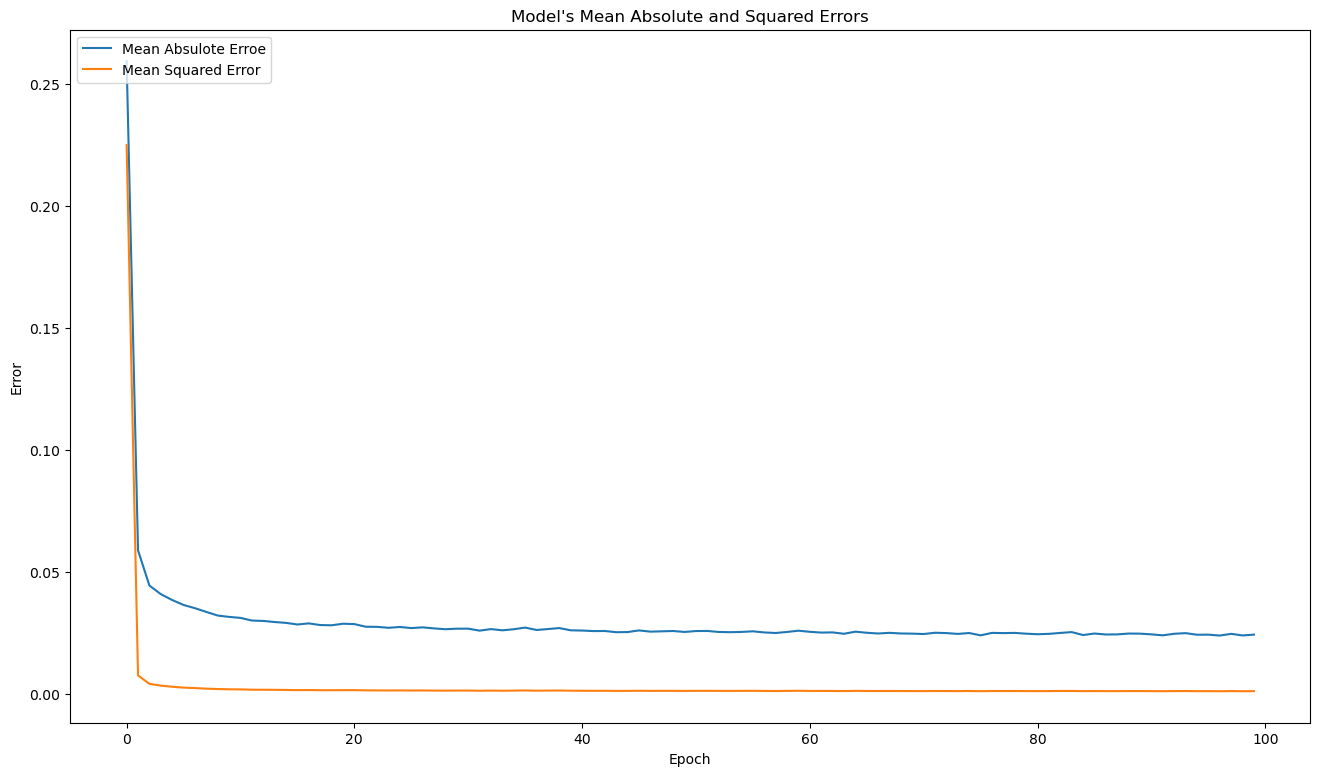

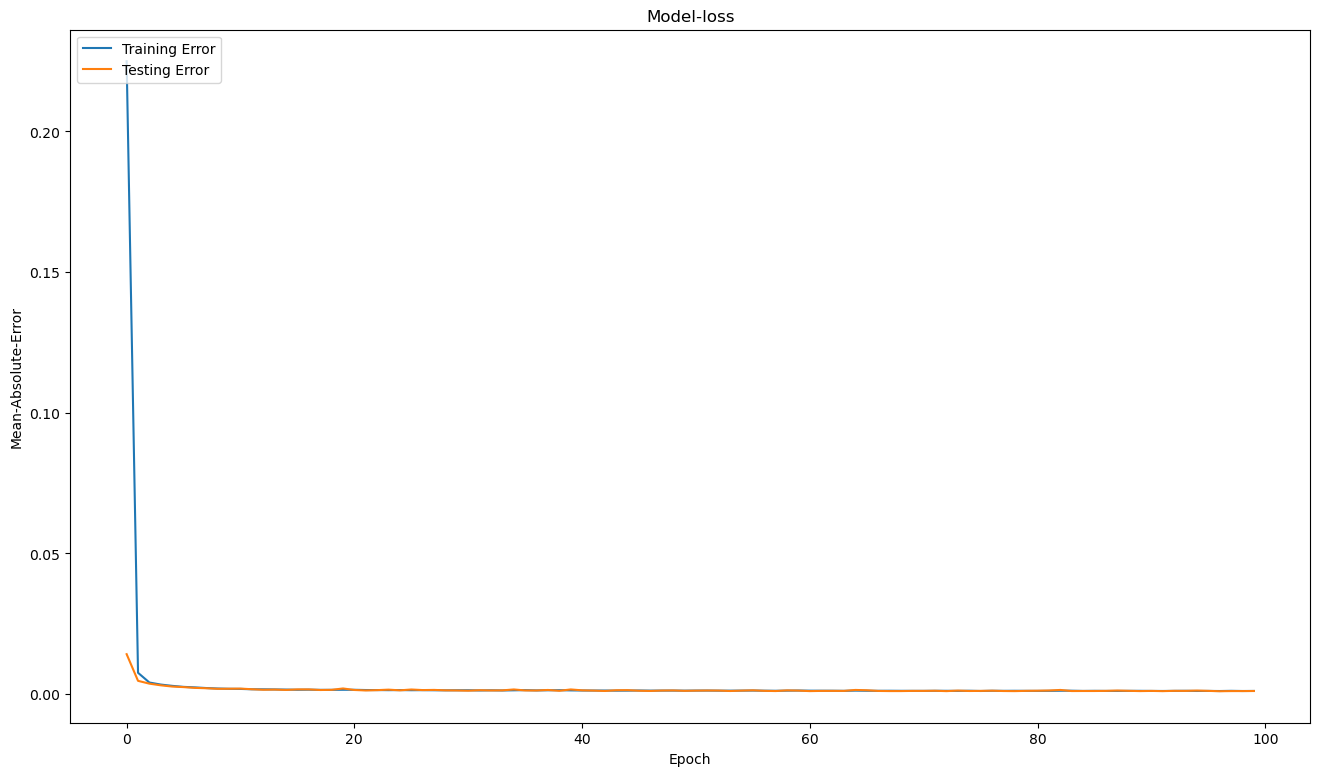

In [37]:
plt.figure(figsize=(16,9))
plt.plot(model.history.history['mae'])
plt.plot(model.history.history['mse'])
plt.title("Model's Mean Absolute and Squared Errors")
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend(['Mean Absulote Erroe', 'Mean Squared Error'],loc = 'upper left')
plt.show()
#summarize history for loss
plt.figure(figsize=(16,9))
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model-loss')
plt.xlabel('Epoch')
plt.ylabel('Mean-Absolute-Error')
plt.legend(['Training Error', 'Testing Error'],loc='upper left')
plt.show()

### Predicting values from Model using same dataset

In [39]:
# generating predictions for test data
y_predict_test = model.predict(x_test) 

# creating table with test price & predicted price for test
predictions_df = pd.DataFrame(x_test)
predictions_df['Actual'] = y_test
predictions_df['Predicted'] = y_predict_test
print(predictions_df.shape)
predictions_df.head(10)

141/141 [==============================] - 0s 2ms/step
(4512, 12)


,AT,AP,AH,AFDP,GTEP,TIT,TAT,CDP,CO,NOX,Actual,Predicted
13312,0.835564,-0.467860,-0.239482,-0.260460,0.082165,0.526478,0.617020,0.105739,-0.318703,-0.691191,0.017154,0.021032
12627,0.354581,0.187310,0.822652,-1.301936,-1.277994,-1.464173,0.577613,-1.188724,0.324554,-1.101497,-1.409324,-1.363116
6393,0.329759,-0.109076,0.273170,0.437015,-0.047454,0.369162,0.536934,0.021436,-0.004500,-0.310779,-0.029595,0.004102
4990,1.201153,-0.140275,-0.642151,0.297704,0.130802,0.550680,0.580155,0.104833,-0.180592,-0.320426,-0.025173,-0.020157
12462,0.217138,-1.076233,0.826567,-1.415726,-1.373111,-1.627540,0.586511,-1.483332,0.147201,-0.905895,-1.479448,-1.455088
7405,-2.052870,-0.015481,0.693891,-1.091062,-1.445228,-1.506528,0.606851,-1.340108,1.036797,3.015029,-1.318353,-1.217450
10993,0.803745,-1.715804,0.366986,-0.543554,-0.006484,0.357060,0.599224,-0.013011,-0.511544,-0.837128,-0.026436,-0.029606
9488,-0.708916,0.982874,1.178630,0.109720,-0.525678,-0.266152,0.534392,-0.547838,0.021286,0.675158,-0.329042,-0.316170
14201,-0.713669,1.482051,0.229887,1.257093,1.700843,0.986324,-2.086836,1.693904,-0.492725,-0.169522,1.593988,1.647820
9757,-1.205003,-1.809399,1.388157,2.276600,1.601892,0.980273,-1.869460,1.595097,3.950035,3.241480,1.748133,1.744045


In [40]:
predictions_df.drop(['CDP','GTEP','TIT','TAT','AFDP','CO','AT'], axis =1 , inplace = True)

In [41]:
# Computing the absolute percent error
APE=100*(abs(predictions_df['Actual']-predictions_df['Predicted'])/predictions_df['Actual'])
print('The Accuracy for Test Data -- ANN model = ', 100-np.mean(APE))

# adding absolute percent error to table
predictions_df['APE %']=APE
predictions_df.head()

The Accuracy for Test Data -- ANN model =  60.829138681411756


,AP,AH,NOX,Actual,Predicted,APE %
13312,-0.467860,-0.239482,-0.691191,0.017154,0.021032,22.605660
12627,0.187310,0.822652,-1.101497,-1.409324,-1.363116,-3.278739
6393,-0.109076,0.273170,-0.310779,-0.029595,0.004102,-113.861015
4990,-0.140275,-0.642151,-0.320426,-0.025173,-0.020157,-19.924380
12462,-1.076233,0.826567,-0.905895,-1.479448,-1.455088,-1.646522


In [42]:
predictions_df['Error'] = (predictions_df['Actual'] - predictions_df['Predicted'])/(predictions_df['Actual'])
predictions_df.reset_index(drop = True)

,AP,AH,NOX,Actual,Predicted,APE %,Error
0,-0.467860,-0.239482,-0.691191,0.017154,0.021032,22.605660,-0.226057
1,0.187310,0.822652,-1.101497,-1.409324,-1.363116,-3.278739,0.032787
2,-0.109076,0.273170,-0.310779,-0.029595,0.004102,-113.861015,1.138610
3,-0.140275,-0.642151,-0.320426,-0.025173,-0.020157,-19.924380,0.199244
4,-1.076233,0.826567,-0.905895,-1.479448,-1.455088,-1.646522,0.016465
...,...,...,...,...,...,...,...
4507,1.341658,0.926691,1.148500,-0.006852,0.170692,-2591.066170,25.910662
4508,-0.889041,1.445288,-0.599216,-1.978526,-1.945164,-1.686206,0.016862
4509,-0.670651,0.545700,0.209457,1.375404,1.368635,0.492158,0.004922
4510,0.202909,1.407660,0.785948,-0.032754,-0.013260,-59.514946,0.595149


In [43]:
# We will evaluate our model performance by calculating the residual sum of squares and the explained variance score
from sklearn import metrics
print("MAE:",metrics.mean_absolute_error(y_test,y_predict_test))
print ("MSE:",metrics.mean_squared_error(y_test,y_predict_test))
print("RMSE:",np.sqrt(metrics.mean_squared_error(y_test,y_predict_test)))

MAE: 0.023846103708654625
MSE: 0.0011426731359663199
RMSE: 0.03380344858097055


In [47]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


print('R2_score (test): ',r2_score(y_test, y_predict_test))

R2_score (test):  0.9988653514432869
